# Chapter 06 Probability Density Functions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import brfss
import thinkstats2
import thinkplot
import math

from IPython.core import page
page.page = print

## PDFs
The derivative of a CDF is called a **probability density function**, or PDF. For example, the PDF of an exponential distribution is

$PDF_{expo}(x) = \lambda e^{-\lambda x}$

The PDF of a normal distribution is

$PDF_{normal}(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{[-\frac{1}{2} (\frac{x-\mu}{\sigma})^2]}$

Evaluating a PDF for a particular value of x is usually not useful. The result is not a probability; it is a **probability density**.

In physics, density is mass per unit of volume; in order to get a mass, you have to multiply by volume or, if the density is not constant, you have to integrate over volume.

Similarly, probability density measures probability per unit of x. In order to get a probability mass, you have to integrate over x.

`thinkstats2` provides a class called `Pdf` that represents a probability density function.

Every Pdf object provides the following methods:
* `Density`, which takes a value, x, and returns the density of the distribution at x.
* `Render`, which evaluates the density at a discrete set of values and returns a pair of sequences: the sorted values, xs, and their probability densities, ds.
* `MakePmf`, which evaluates Density at a discrete set of values and returns a normalized Pmf that approximates the Pdf.
* `GetLinspace`, which returns the default set of points used by Render and MakePmf.

`Pdf` is an abstract parent class, which means you should not instantiate it; that is, you cannot create a `Pdf` object. Instead, you should define a child class that inherits from `Pdf` and provides definitions of `Density` and `GetLinspace`. `Pdf` provides `Render` and `MakePmf`.

For example, thinkstats2 provides a class named `NormalPdf` that evaluates the normal density function.

In [3]:
%psource thinkstats2.NormalPdf

class NormalPdf(Pdf):
    """Represents the PDF of a Normal distribution."""

    def __init__(self, mu=0, sigma=1, label=None):
        """Constructs a Normal Pdf with given mu and sigma.

        mu: mean
        sigma: standard deviation
        label: string
        """
        self.mu = mu
        self.sigma = sigma
        self.label = label if label is not None else '_nolegend_'

    def __str__(self):
        return 'NormalPdf(%f, %f)' % (self.mu, self.sigma)

    def GetLinspace(self):
        """Get a linspace for plotting.

        Returns: numpy array
        """
        low, high = self.mu-3*self.sigma, self.mu+3*self.sigma
        return np.linspace(low, high, 101)

    def Density(self, xs):
        """Evaluates this Pdf at xs.

        xs: scalar or sequence of floats

        returns: float or NumPy array of probability density
        """
        return stats.norm.pdf(xs, self.mu, self.sigma)



The `NormalPdf` object contains the parameters `mu` and `sigma`. 

`Density` uses `scipy.stats.norm`, which is an object that represents a normal distribution and provides `cdf` and `pdf`, among other methods.

The following example creates a `NormalPdf` with the mean and variance of adult female heights, in cm, from the BRFSS. Then it computes the density of the distribution at a location one standard deviation from the mean.

We'll start with the data from the BRFSS again.

In [2]:
df = brfss.ReadBrfss(nrows=None)

In [3]:
df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


Here are the mean and standard deviation of female height in cm.

In [6]:
female = df[df.sex==2]
female_heights = female.htm3.dropna()
mean, std = female_heights.mean(), female_heights.std()
mean, std

(163.22347500412215, 7.269156286641344)

`NormalPdf` returns a `Pdf` object that represents the normal distribution with the given parameters.

`Density` returns a probability density, which doesn't mean much by itself.

In [12]:
pdf = thinkstats2.NormalPdf(mean, std)
pdf.Density(mean + std)

0.035539693607303746

The result is about 0.03, in units of probability mass per cm. 

Again, a probability density doesn’t mean much by itself. But if we plot the Pdf, we can see the shape of the distribution.

`thinkplot.Pdf` plots the `Pdf` as a smooth function, as contrasted with `thinkplot.Pmf`, which renders a `Pmf` as a step function. 

You can use MakePmf to approximate the Pdf:

`thinkplot` provides `Pdf`, which plots the probability density with a smooth curve.

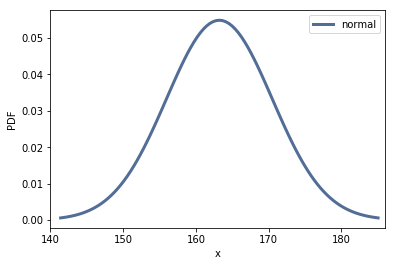

In [8]:
thinkplot.Pdf(pdf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

In [9]:
pmf = pdf.MakePmf()

By default, the resulting `Pmf` contains 101 points equally spaced from `mu - 3*sigma to mu + 3*sigma`. 

Optionally, `MakePmf` and `Render` can take keyword arguments `low`, `high`, and `n`.

`Pdf` provides `MakePmf`, which returns a `Pmf` object that approximates the `Pdf`. 

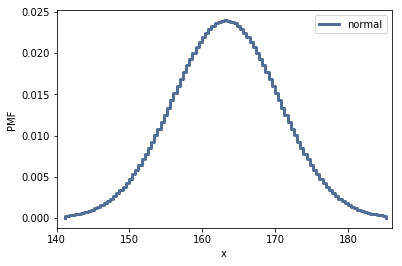

In [13]:
thinkplot.Pmf(pmf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PMF', xlim=[140, 186])

If you have a `Pmf`, you can also plot it using `Pdf`, if you have reason to think it should be represented as a smooth curve.

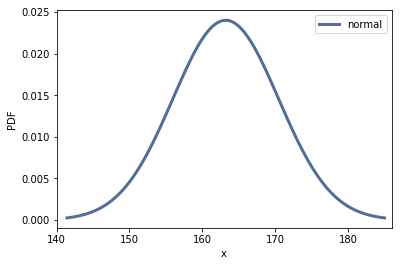

In [11]:
thinkplot.Pdf(pmf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

## Kernel Density Estimation
Kernel density estimation (KDE) is an algorithm that takes a sample and finds an appropriately smooth PDF that fits the data. You can read details at [Wikipedia](https://en.wikipedia.org/wiki/Kernel_density_estimation).

`scipy` provides an implementation of KDE and thinkstats2 provides a class called `EstimatedPdf` that uses it:

In [14]:
%psource thinkstats2.EstimatedPdf

class EstimatedPdf(Pdf):
    """Represents a PDF estimated by KDE."""

    def __init__(self, sample, label=None):
        """Estimates the density function based on a sample.

        sample: sequence of data
        label: string
        """
        self.label = label if label is not None else '_nolegend_'
        self.kde = stats.gaussian_kde(sample)
        low = min(sample)
        high = max(sample)
        self.linspace = np.linspace(low, high, 101)

    def __str__(self):
        return 'EstimatedPdf(label=%s)' % str(self.label)

    def GetLinspace(self):
        """Get a linspace for plotting.

        Returns: numpy array
        """
        return self.linspace

    def Density(self, xs):
        """Evaluates this Pdf at xs.

        returns: float or NumPy array of probability density
        """
        return self.kde.evaluate(xs)

    def Sample(self, n):
        """Generates a random sample from the estimated Pdf.

        n: size of sample
        """
        # NOTE: 

`__init__` takes a sample and computes a kernel density estimate. The result is a `gaussian_kde` object that provides an `evaluate` method.

`Density` takes a value or sequence, calls `gaussian_kde.evaluate`, and returns the resulting density. The word “Gaussian” appears in the name because it uses a filter based on a Gaussian distribution to smooth the KDE.

Here’s an example that generates a sample from a normal distribution and then makes an `EstimatedPdf` to fit it:

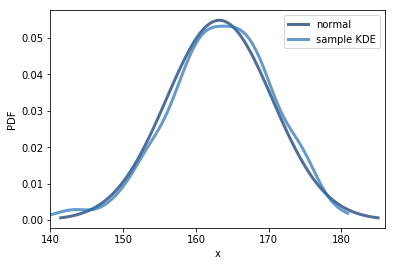

In [25]:
# If you run this a few times, you'll see how much variation there is in the estimate.
thinkplot.Pdf(pdf, label='normal')

sample = np.random.normal(mean, std, 500)
# Using a sample from the actual distribution, we can estimate the PDF using Kernel Density Estimation (KDE).
sample_pdf = thinkstats2.EstimatedPdf(sample, label='sample')

thinkplot.Pdf(sample_pdf, label='sample KDE')

thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

`sample` is a list of 500 random heights. `sample_pdf` is a `Pdf` object that contains the estimated KDE of the sample. `pmf` is a `Pmf` object that approximates the `Pdf` by evaluating the density at a sequence of equally spaced values.

Figure shows the normal density function and a KDE based on a sample of 500 random heights. The estimate is a good match for the original distribution.

Estimating a density function with KDE is useful for several purposes:

* **Visualization**<br>
During the exploration phase of a project, CDFs are usually the best visualization of a distribution. After you look at a CDF, you can decide whether an estimated PDF is an appropriate model of the distribution. If so, it can be a better choice for presenting the distribution to an audience that is unfamiliar with CDFs.

* **Interpolation**<br>
An estimated PDF is a way to get from a sample to a model of the population. If you have reason to believe that the population distribution is smooth, you can use KDE to interpolate the density for values that don’t appear in the sample.

* **Simulation**<br>
Simulations are often based on the distribution of a sample. If the sample size is small, it might be appropriate to smooth the sample distribution using KDE, which allows the simulation to explore more possible outcomes, rather than replicating the observed data.

## The Distribution Framework
At this point we have seen PMFs, CDFs and PDFs; let’s take a minute to review. Figure shows how these functions relate to each other.

![title](distribution_functions.png)

We started with PMFs, which represent the probabilities for a discrete set of values. To get from a PMF to a CDF, you add up the probability masses to get cumulative probabilities.

To get from a CDF back to a PMF, you compute differences in cumulative probabilities. We’ll see the implementation of these operations in the next few sections.

A PDF is the derivative of a continuous CDF; or, equivalently, a CDF is the integral of a PDF. Remember that a PDF maps from values to probability densities; to get a probability, you have to integrate.

To get from a discrete to a continuous distribution, you can perform various kinds of smoothing. 
* One form of smoothing is to assume that the data come from an analytic continuous distribution (like exponential or normal) and to estimate the parameters of that distribution. 
* Another option is kernel density estimation. 

The opposite of smoothing is discretizing, or quantizing. If you evaluate a PDF at discrete points, you can generate a PMF that is an approximation of the PDF. You can get a better approximation using numerical integration.

To distinguish between continuous and discrete CDFs, it might be better for a discrete CDF to be a **“cumulative mass function,”** but as far as I can tell no one uses that term.

## Hist Implementation

At this point you should know how to use the basic types provided by thinkstats2: Hist, Pmf, Cdf, and Pdf.

The next few sections provide details about how they are implemented. This material might help you use these classes more effectively, but it is not strictly necessary.

`Hist` and `Pmf` inherit from a parent class called `_DictWrapper`. The leading underscore indicates that this class is “internal”; that is, it should not be used by code in other modules.

The name indicates what it is: a dictionary wrapper. Its primary attribute is `d`, the dictionary that maps from values to their frequencies.

The values can be any hashable type. The frequencies should be integers, but can be any numeric type.

`_DictWrapper` contains methods appropriate for both `Hist` and `Pmf`, including `__init__`, `Values`, `Items` and `Render`. It also provides modifier methods `Set`, `Incr`, `Mult`, and `Remove`. These methods are all implemented with dictionary operations. For example:

In [ ]:
%psource thinkstats2._DictWrapper

`Hist` also provides `Freq`, which looks up the frequency of a given value.

Because `Hist` operators and methods are based on dictionaries, these methods are constant time operations; that is, their runtime does not increase as the `Hist` gets bigger.

## Pmf Implementation
`Pmf` and `Hist` are almost the same thing, except that a `Pmf` maps values to floating-point probabilities, rather than integer frequencies.

If the sum of the probabilities is 1, the `Pmf` is normalized.

`Pmf` provides `Normalize`, which computes the sum of the probabilities and divides through by a factor:

In [ ]:
%psource thinkstats2.Pmf.Normalize

`fraction` determines the sum of the probabilities after normalizing; the default value is 1. 

If we have a set of numbers and we want them all to add up to 1, we think we should sum them and divide each value by the sum. Actually this is not the case. We first decide what the numbers shuuld add up to. If its 1 then we multiply each value by 1/sum. If we want it to add up to 100, we multiply by 100/sum.

If the total probability is 0, the Pmf cannot be normalized, so `Normalize` raises `ValueError`.

`Hist` and `Pmf` have the same constructor. It can take as an argument a dict, `Hist`, `Pmf` or `Cdf`, a pandas Series, a list of (value, frequency) pairs, or a sequence of values.

If you instantiate a `Pmf`, the result is normalized. If you instantiate a `Hist`, it is not.

To construct an unnormalized `Pmf`, you can create an empty Pmf and modify it. The Pmf modifiers do not renormalize the Pmf.

## Cdf Implementation
A CDF maps from *values to cumulative probabilities*, so we could have implemented `Cdf` as a `_DictWrapper`. But the values in a CDF are ordered and the values in a `_DictWrapper` are not. 

Also, it is often useful to compute the inverse CDF; that is, the map from cumulative probability to value. So the implementaion we chose is two sorted lists. That way we can use binary search to do a forward or inverse lookup in logarithmic time.

The `Cdf` constructor can take as a parameter a sequence of values or a pandas Series, a dictionary that maps from values to probabilities, a sequence of (value, probability) pairs, a `Hist`, `Pmf`, or `Cdf`. Or if it is given two parameters, it treats them as a sorted sequence of values and the sequence of corresponding cumulative probabilities.

Given a sequence, pandas Series, or dictionary, the constructor makes a Hist. Then it uses the Hist to initialize the attributes:

In [ ]:
%psource thinkstats2.Cdf.__init__

See last 4 lines:

`xs` is the sorted list of values; `freqs` is the list of corresponding frequencies. `np.cumsum` computes the cumulative sum of the frequencies. 

Dividing through by the total frequency yields cumulative probabilities. [-1] is the last item, which also contains the total items in the distribution because its cumulative. For n values, the time to construct the Cdf is
proportional to n log n.

https://treyhunner.com/2018/10/asterisks-in-python-what-they-are-and-how-to-use-them/

Here is the implementation of Prob, which takes a value and returns its cumulative probability:

In [ ]:
%psource thinkstats2.Cdf.Prob

The `bisect` module provides an implementation of binary search. And here is the implementation of `Value`, which takes a cumulative probability and returns the corresponding value:

In [ ]:
%psource thinkstats2.Cdf.Value

Given a `Cdf`, we can compute the `Pmf` by computing differences between consecutive cumulative probabilities. If you call the `Cdf` constructor and pass a `Pmf`, it computes differences by calling `Cdf.Items`:

In [ ]:
%psource thinkstats2.Cdf.Items

`np.roll` shifts the elements of `a` to the right, and “rolls” the last one back to the beginning.

We replace the first element of `b` with 0 and then compute the difference `a-b`. The result is a NumPy array of probabilities.

Cdf provides `Shift` and `Scale`, which modify the values in the `Cdf`, but the probabilities should be treated as immutable.

## Moments

Any time you take a sample and reduce it to a single number, that number is a **statistic**.

The statistics we have seen so far include mean, variance, median, and interquartile range.

A **raw moment** is a kind of statistic. If you have a sample of values, $x_i$, the kth raw moment is:

$m_k = \frac{1}{n} \sum_{i} x_{i}^k$

(Raise every element by the power of k, sum them, then divide by the number of items)

Raw moments are just sums of powers.

In [ ]:
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

The first raw moment (When k = 1) is the mean $\bar x$.  

The other raw moments don’t mean much by themselves, but they are used in some computations.

In [ ]:
RawMoment(female_heights, 1), RawMoment(female_heights, 2), RawMoment(female_heights, 3)

In [ ]:
def Mean(xs):
    return RawMoment(xs, 1)

Mean(female_heights)

The central moments are powers of distances from the mean.

$m_k = \frac{1}{n} \sum_{i} (x_i - \bar x)^k$

(Subtract the mean from every element and raise by the power of k, add them, then divide by the number of items)

In [ ]:
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

The first central moment is approximately 0.

When k = 2 the result is the second central moment, which you might recognize as variance.

The definition of variance gives a hint about why these statistics are called moments. If we attach a weight along a ruler at each location, $x_i$, and then spin the ruler around the mean, the moment of inertia of the spinning weights is the variance of the values.

If you are not familiar with moment of inertia, see [Wikipedia](https://en.wikipedia.org/wiki/Moment_of_inertia).

When you report moment-based statistics, it is important to think about the units. For example, if the values $x_i$ are in cm, the first raw moment is also in cm. But the second moment is in $cm^2$, the third moment is in $cm^3$, and so on.

Because of these units, moments are hard to interpret by themselves. That’s why, for the second moment, it is common to report standard deviation, which is the square root of variance, so it is in the same units as $x_i$.

In [ ]:
CentralMoment(female_heights, 1), CentralMoment(female_heights, 2), CentralMoment(female_heights, 3)

In [ ]:
def Var(xs):
    return CentralMoment(xs, 2)

Var(female_heights)

## Skewness
Skewness is a property that describes the shape of a distribution. If the distribution is symmetric around its central tendency, it is unskewed. If the values extend farther to the right, it is “right skewed” and if the values extend left, it is “left skewed.”

This use of “skewed” does not have the usual connotation of “biased.” Skewness only describes the shape of the distribution; it says nothing about whether the sampling process might have been biased.

Several statistics are commonly used to quantify the skewness of a distribution. Given a sequence of values, $x_i$, the **sample skewness**, $g_1$, can be computed like this:

The standardized moments are ratios of central moments, with powers chosen to make the dimensions cancel.

In [ ]:
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

$g_1$ is the third standardized moment, which means that it has been normalized so it has no units.

The third standardized moment is skewness.

In [ ]:
StandardizedMoment(female_heights, 1), StandardizedMoment(female_heights, 2), StandardizedMoment(female_heights, 3)

In [ ]:
def Skewness(xs):
    return StandardizedMoment(xs, 3)

Skewness(female_heights)

Negative skewness indicates that a distribution skews left; positive skewness indicates that a distribution skews right.

The magnitude of $g_1$ indicates the strength of the skewness, but by itself it is not easy to interpret. 

In that case, the mean is usually less than the median.

Another way to evaluate the asymmetry of a distribution is to look at the relationship between the mean and the median. Extreme values have more effect on the mean than the median, so in a distribution that skews left, the mean is less than the median. In a distribution that skews right, the mean is greater.

But in this case the mean is greater than the median, which indicates skew to the right.

In [ ]:
def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

In [ ]:
Mean(female_heights), Median(female_heights)

Because the skewness is based on the third moment, it is not robust (because things are raised to the power of 3 so outliers get exponentially large); that is, it depends strongly on a few outliers.  

In practice, computing sample skewness is usually not a good idea. If there are any outliers, they have a disproportionate effect on $g_1$.

Pearson's median skewness is more robust.

**Pearson’s median skewness coefficient** is a measure of skewness based on the difference between the sample mean and median:

$ g_p = 3 \frac{(\bar x - m)}{S} $

Where $\bar x$ is the sample mean, m is the median, and S is the standard deviation.

In [ ]:
def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

In [ ]:
PearsonMedianSkewness(female_heights)

Pearson's skewness is positive, indicating that the distribution of female heights is slightly skewed to the right.

This statistic is robust, which means that it is less vulnerable to the effect of outliers.

## Birth weights

As an example, let’s look at the skewness of birth weights in the NSFG pregnancy data.

In [ ]:
import first

live, firsts, others = first.MakeFrames()

Based on KDE, it looks like the distribution is skewed to the left.

In [ ]:
birth_weights = live.totalwgt_lb.dropna()
pdf = thinkstats2.EstimatedPdf(birth_weights)
thinkplot.Pdf(pdf, label='birth weight')
thinkplot.Config(xlabel='Birth weight (pounds)', ylabel='PDF')

The mean is less than the median, which is consistent with left skew.

The left tail appears longer than the right, so we suspect the distribution is skewed left. The mean, 7.27 lbs, is a bit less than the median, 7.38 lbs, so that is consistent with left skew.

In [ ]:
Mean(birth_weights), Median(birth_weights)

And both ways of computing skew are negative, which is consistent with left skew.

In [ ]:
Skewness(birth_weights), PearsonMedianSkewness(birth_weights)

## Adult weights

Now let’s compare this distribution to the distribution of adult weight in the BRFSS.

In [ ]:
adult_weights = df.wtkg2.dropna()
pdf = thinkstats2.EstimatedPdf(adult_weights)
thinkplot.Pdf(pdf, label='Adult weight')
thinkplot.Config(xlabel='Adult weight (kg)', ylabel='PDF')

The distribution appears skewed to the right. The mean is greater than the median, which is consistent with skew to the right.

Sure enough, the mean, 79.0, is bigger than the median, 77.3.

In [ ]:
Mean(adult_weights), Median(adult_weights)

In [ ]:
Skewness(adult_weights), PearsonMedianSkewness(adult_weights)

And both ways of computing skewness are positive.

The sample skewness is 1.05 and Pearson’s median skewness is 0.26.

The *sign of the skewness coefficient indicates whether the distribution skews left or right, but other than that, they are hard to interpret*. 

Sample skewness is less robust; that is, it is more susceptible to outliers. As a result it is less reliable when applied to skewed distributions, exactly when it would be most relevant.

Pearson’s median skewness is based on a computed mean and variance, so it is also susceptible to outliers, but since it does not depend on a third moment, it is somewhat more robust.

## Exercises

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income "Under \\$5000." The highest range includes respondents who made "\\$250,000 or more."

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [ ]:
import hinc
income_df = hinc.ReadData()

In [ ]:
income_df.head()

In [ ]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, row.freq)
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample


In [ ]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

In [ ]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [ ]:
# convert back to linear space by raising all elements by the power of 10
sample = np.power(10, log_sample)

In [ ]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [ ]:
# Solution

Mean(sample), Median(sample)

In [ ]:
# Solution

Skewness(sample), PearsonMedianSkewness(sample)

In [ ]:
# Solution

# About 66% of the population makes less than the mean

cdf.Prob(Mean(sample))

All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.  What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.